In [1]:
# uses Python 3.8.5

<font face=Nunito size=5> Code </font>

How to Build a Profitable Python Trading Algorithm in 5 Minutes (YouTube)

**<u>Model Components</u>**  

1. IWO - Russeel 2000 Growth ETF  
1. TLT - Treasury Bond ETF  
1. QQQ - NASDAQ ETF  

Source: StockCharts or Yahoo Finance

**<u>Model Rules</u>**  
- Buy QQQ when IWO is GREATER than it's 150(day) EMA (or) IWO's 5(day) EMA is GREATER than it's 10(day) EMA. (*EMA = exponential moving average)
- Otherwise buy TLT

In [6]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# Part 1: get data

In [24]:
# 0th column is interpredate as a date usinf parse_dates
df0 = pd.read_csv("data_files/data_5min_py_algo.csv", parse_dates=[0])
df0

,Date,IWO,TLT,QQQ
0,2014-10-29,127.686172,103.026131,94.232361
1,2014-10-30,128.961349,103.112381,94.430649
2,2014-10-31,130.969223,102.845039,95.733528
3,2014-11-03,130.769379,102.845055,96.016754
4,2014-11-04,130.160339,103.164894,95.695778
...,...,...,...,...
1408,2020-06-04,203.856689,155.674240,233.902069
1409,2020-06-05,209.921005,154.565308,238.539719
1410,2020-06-08,212.768936,155.159378,240.390778
1411,2020-06-09,209.811447,156.921738,242.132385


In [37]:
# Part 2: Calculate the inputs that go into the model
# We use the simple percentage change.
# We also find the Exponential WeightMoving Average for each.
# note that our datafrmae is in ascending order

df0["TLT_pct_change"] = df["TLT"].pct_change()
df0["QQQ_pct_change"] = df["QQQ"].pct_change()
df0["EMA 005"] = df["IWO"].ewm(span=5, adjust=False).mean()
df0["EMA 010"] = df["IWO"].ewm(span=10, adjust=False).mean()
df0["EMA 150"] = df["IWO"].ewm(span=150, adjust=False).mean()

In [38]:
df0.head()

,Date,IWO,TLT,QQQ,TLT_pct_change,QQQ_pct_change,EMA 005,EMA 010,EMA 150
0,2014-10-29,127.686172,103.026131,94.232361,NaN,NaN,127.686172,127.686172,127.686172
1,2014-10-30,128.961349,103.112381,94.430649,8.371663e-04,0.002104,128.111231,127.918022,127.703062
2,2014-10-31,130.969223,102.845039,95.733528,-2.592725e-03,0.013797,129.063895,128.472786,127.746322
3,2014-11-03,130.769379,102.845055,96.016754,1.555739e-07,0.002958,129.632390,128.890348,127.786363
4,2014-11-04,130.160339,103.164894,95.695778,3.109911e-03,-0.003343,129.808373,129.121256,127.817806


In [82]:
# We trim the df to start from row 150, sicne we used a 150-day exp moving average
df = pd.DataFrame.copy(df0.iloc[150:],deep=True)
df.head()

,Date,IWO,TLT,QQQ,TLT_pct_change,QQQ_pct_change,EMA 005,EMA 010,EMA 150
150,2015-06-05,147.958511,103.168785,103.814781,-0.012180,-0.002373,147.116701,146.628816,140.043525
151,2015-06-08,147.327621,103.054771,102.760468,-0.001105,-0.010156,147.187008,146.755871,140.140003
152,2015-06-09,146.438660,102.238838,102.589516,-0.007917,-0.001664,146.937559,146.698196,140.223429
153,2015-06-10,148.283524,101.344048,103.995232,-0.008752,0.013702,147.386214,146.986438,140.330185
154,2015-06-11,148.656311,103.475876,104.147202,0.021036,0.001461,147.809579,147.290051,140.440465


In [83]:
# Part 3: Model's Criteria
# We calculate model's criteria here. Basically, we create a True or False decision for each day
# As mentioned above:

    # Buy QQQ when...
df["QQQ Criteria"] = ( df["IWO"] > df["EMA 150"] ) | ( df["EMA 005"] > df["EMA 010"] )

    # Buy TLT when ...
df["TLT Criteria"] = np.logical_not( df["QQQ Criteria"] )

In [84]:
df.iloc[:,-5:]

,EMA 005,EMA 010,EMA 150,QQQ Criteria,TLT Criteria
150,147.116701,146.628816,140.043525,True,False
151,147.187008,146.755871,140.140003,True,False
152,146.937559,146.698196,140.223429,True,False
153,147.386214,146.986438,140.330185,True,False
154,147.809579,147.290051,140.440465,True,False
...,...,...,...,...,...
1408,202.566894,199.547712,189.086716,True,False
1409,205.018265,201.433765,189.362667,True,False
1410,207.601822,203.494705,189.672684,True,False
1411,208.338363,204.643204,189.939422,True,False


In [85]:
df["QQQ Criteria"].value_counts()

True     1030
False     233
Name: QQQ Criteria, dtype: int64

In [86]:
df["QQQ Criteria"].describe()

count     1263
unique       2
top       True
freq      1030
Name: QQQ Criteria, dtype: object

In [87]:
# Part 4: Calculate the model
# We calculate the model values in this way:
    # If yesterday's QQQ Criteria was true, we hold QQQ.
    # If yesterday's TLT Critera was true, we hold TLT.
# By "hold" what me mean is we multiply the criteria (a True boolen =1) by today's percentage change
    # in either QQQ or TLT. This similatesa gain/loss from executing the strategy.
# Since we are trading in both QQQ and TLT, add the gain/loss from executing on the
    # yesterday's QQQ Criteria to the gain/loss fro mexecuting on the yesterday's TLT (Criteria)


df["model_flat"] = 100 * ( 1 + ( df["QQQ Criteria"].shift(1) * df.QQQ_pct_change) +
                     ( df["TLT Criteria"].shift(1) * df.TLT_pct_change ))
df["model"] = 100 * ( 1 + ( df["QQQ Criteria"].shift(1) * df.QQQ_pct_change) +
                     ( df["TLT Criteria"].shift(1) * df.TLT_pct_change )).cumprod()

In [88]:
df.iloc[:,-6:].head()

,EMA 010,EMA 150,QQQ Criteria,TLT Criteria,model_flat,model
150,146.628816,140.043525,True,False,NaN,NaN
151,146.755871,140.140003,True,False,98.9844,98.9844
152,146.698196,140.223429,True,False,99.8336,98.8198
153,146.986438,140.330185,True,False,101.37,100.174
154,147.290051,140.440465,True,False,100.146,100.32


In [89]:
df.iloc[:,-6:].describe()

,EMA 010,EMA 150
count,1263.000000,1263.000000
mean,169.848213,167.094788
std,27.871744,25.972537
min,112.429059,128.290856
25%,144.087450,140.872597
50%,172.574417,168.965485
75%,193.990704,192.504352
max,221.568446,206.506330


In [90]:
df.iloc[:,-6:]

,EMA 010,EMA 150,QQQ Criteria,TLT Criteria,model_flat,model
150,146.628816,140.043525,True,False,NaN,NaN
151,146.755871,140.140003,True,False,98.9844,98.9844
152,146.698196,140.223429,True,False,99.8336,98.8198
153,146.986438,140.330185,True,False,101.37,100.174
154,147.290051,140.440465,True,False,100.146,100.32
...,...,...,...,...,...,...
1408,199.547712,189.086716,True,False,99.2987,254.069
1409,201.433765,189.362667,True,False,101.983,259.106
1410,203.494705,189.672684,True,False,100.776,261.117
1411,204.643204,189.939422,True,False,100.724,263.009


In [94]:
# Part 5: Calculate the model's statistics

# Average yearly return
start_model = df.model.iloc[150]
end_model = df.model.iloc[-1]
years = (df["model"].count()+1-150)/252
model_average_return = (end_model/start_model)**(1/years)-1
print(f"Model Yields {model_average_return*100} % per year")

# Maximum Drawdown
df["Drawdown"] = (df["model"]/df.model.cummax()-1)*100
drawdown = df.Drawdown.min()
print(f"Drawdown : {drawdown}")

Model Yields 24.627259179358063 % per year
Drawdown : -16.961909217321814


In [95]:
# Part 6: Plot the model
# We plot it with and without a log scale.

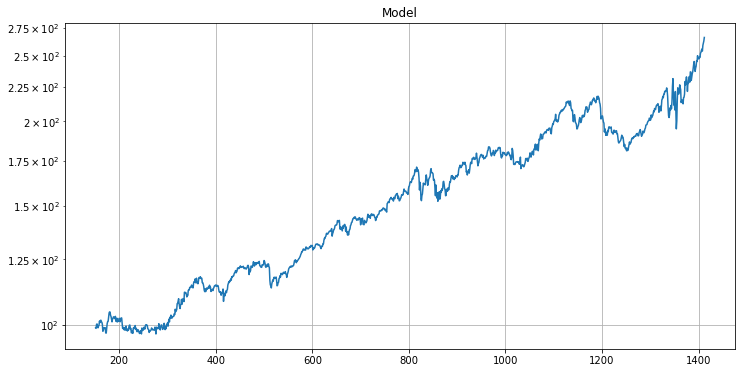

In [103]:
df["model"].plot(grid=True, kind="line", title="Model", logy=True, figsize=(12,6))
plt.show()

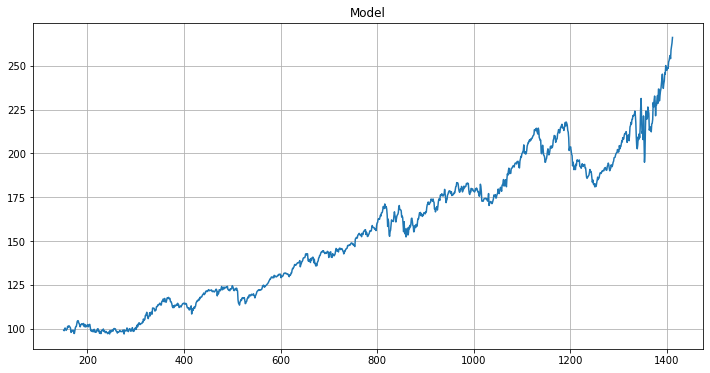

In [104]:
df["model"].plot(grid=True, kind="line", title="Model", logy=False, figsize=(12,6))
plt.show()

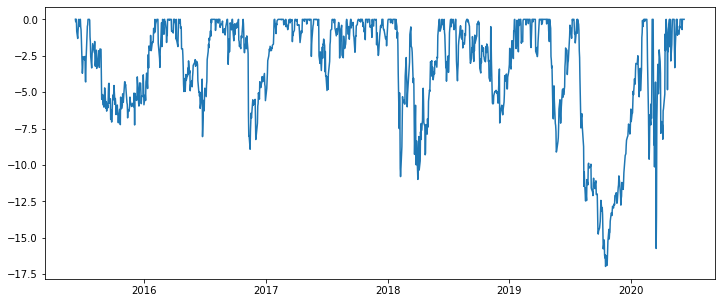

In [119]:
# Part 7: Plot the Maximum Drawdown
x = df["Date"]
y = df["Drawdown"]
plt.figure(figsize=(12,5))
plt.plot(x,y)
plt.show()